In [39]:
import pandas as pd
import glob
import pandas as pd
import numpy as np
import datetime
import math
from ast import literal_eval
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
from ast import literal_eval

# imports to load model
from keras.models import model_from_json
from sklearn.preprocessing import StandardScaler
import pickle

# imports for visualization
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [40]:
# Functions
def ct_numbers_list(ct_numbers_in_heart):
    ls = literal_eval(ct_numbers_in_heart)
    ints = list()
    for x in ls:
        ints.append(int(x))
    return(ints)


def consolidate_data(df, included_cacs):
    d = list()
    for patient_id in df.pt_id.unique():
        dfp = df[df.pt_id == patient_id]

        data = {'patient_id': patient_id,
                'total_score': dfp.total_score.max(),
                'label': 1 if dfp.total_score.max() >= 100 else 0,
                'total_hhua_pixels':dfp.number_of_pixels.sum(),
                'cts_with_cac': len(dfp.ct_number.unique()),
                'slice_thickness': dfp.slice_thickness.max(),
                'pixel_spacing_1': dfp.pixel_spacing_1.max(),
                }
                
        dfp.sort_values(by=['number_of_pixels'])
        dfp = dfp.reset_index()

        dfp['center_lit'] = dfp.center_min_circle.apply(literal_eval)
        dfp['center_1'] = 0
        dfp['center_2'] = 0
        dfp.loc[:, 'center_1'] = dfp.center_lit.map(lambda x: x[0])
        dfp.loc[:, 'center_2'] = dfp.center_lit.map(lambda x: x[1])

        dfp['cropedlit'] = dfp.croped_slice_shape.apply(literal_eval)
        dfp['croped_1'] = 0
        dfp['croped_2'] = 0
        dfp.loc[:, 'croped_1'] = dfp.cropedlit.map(lambda x: x[0])
        dfp.loc[:, 'croped_2'] = dfp.cropedlit.map(lambda x: x[1])
     
        for i in range(included_cacs):
            try:
                data[f'hhua_{i}_area'] = dfp.iloc[i].number_of_pixels  * data['pixel_spacing_1']**2 

                data[f'hhua_{i}_dist_x1'] = dfp.iloc[i]['center_1'] * data['pixel_spacing_1']
                data[f'hhua_{i}_dist_x2'] = (dfp.iloc[i]['croped_1'] - dfp.iloc[i]['center_1'])* data['pixel_spacing_1']

                data[f'hhua_{i}_dist_y1'] = dfp.iloc[i]['center_2'] * data['pixel_spacing_1']
                data[f'hhua_{i}_dist_y2'] = (dfp.iloc[i]['croped_2'] - dfp.iloc[i]['center_2'])* data['pixel_spacing_1']

                data[f'hhua_{i}_dist_z1'] = (dfp.iloc[i].ct_max - dfp.iloc[i].ct_number) * data['slice_thickness']
                data[f'hhua_{i}_dist_z2'] = (dfp.iloc[i].ct_number - dfp.iloc[i].ct_min ) * data['slice_thickness']

                data[f'hhua_{i}_ct_number'] = dfp.iloc[i].ct_number

                data[f'hhua_{i}_max_pixel_value'] = dfp.iloc[i].max_pixel_value
                data[f'hhua_{i}_min_pixel_value'] = dfp.iloc[i].min_pixel_value
                data[f'hhua_{i}_mean_pixel_value'] = dfp.iloc[i].mean_pixel_value
                
            except IndexError:
                data[f'hhua_{i}_area'] = 0
                data[f'hhua_{i}_ct_number'] = 0
                data[f'hhua_{i}_dist_x1'] = 0
                data[f'hhua_{i}_dist_y1'] = 0
                data[f'hhua_{i}_dist_z1'] = 0
                data[f'hhua_{i}_dist_x2'] = 0
                data[f'hhua_{i}_dist_y2'] = 0
                data[f'hhua_{i}_dist_z2'] = 0
                data[f'hhua_{i}_max_pixel_value'] = 0
                data[f'hhua_{i}_min_pixel_value'] = 0
                data[f'hhua_{i}_mean_pixel_value'] = 0

        d.append(data)
    return(d)    

In [41]:
df_patients = pd.read_csv("DSproject/patient_overview_test.csv")
df_manual = pd.read_csv("DSproject/manual_labels_test.csv")
df_slices = pd.read_csv("DSproject/ct_slices_test.csv")

df_patients = pd.merge(df_patients, df_manual[['pt_id', 'Total_score']], on='pt_id')
df_patients['ct_list'] = df_patients.ct_numbers_in_heart.apply(ct_numbers_list)
df_patients['ct_max'] = df_patients.ct_list.apply(max)
df_patients['ct_min'] = df_patients.ct_list.apply(min)
df_patients['ct_len'] = df_patients.ct_list.apply(len)

df_slices['number_of_pixels'] = df_slices.pixel_values_hu.apply(literal_eval).apply(len)
df_slices['max_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(max)
df_slices['min_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(min)
df_slices['mean_pixel_value'] = df_slices.pixel_values_hu.apply(literal_eval).apply(np.mean)

# apply the same total score to all slices of the same patient
df_slices['total_score'] = 0
for patient_id in df_slices.pt_id.unique():
    df_slices.loc[(df_slices.pt_id == patient_id), 'total_score'] = df_patients.loc[(df_patients.pt_id == patient_id), 'Total_score'].values[0]

df_slices['ct_max']= 0
df_slices['ct_min'] =0

for patient_id in df_slices.pt_id.unique():
    df_slices.loc[(df_slices.pt_id == patient_id), 'ct_max'] = df_patients.loc[(df_patients.pt_id == patient_id), 'ct_max'].values[0]
    df_slices.loc[(df_slices.pt_id == patient_id), 'ct_min'] = df_patients.loc[(df_patients.pt_id == patient_id), 'ct_min'].values[0]

C:\Users\frede\AppData\Local\Temp\ipykernel_14756\1122636615.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '37.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_slices.loc[(df_slices.pt_id == patient_id), 'total_score'] = df_patients.loc[(df_patients.pt_id == patient_id), 'Total_score'].values[0]


# Performance of logistic regression and neural network on unseen test data

In [42]:
df_features = pd.DataFrame(consolidate_data(df_slices, 29))

# drop rows with slice_thickness == 5.0
df_features = df_features[df_features.slice_thickness != 5.0]
df_features[:5]

,patient_id,total_score,label,total_hhua_pixels,cts_with_cac,slice_thickness,pixel_spacing_1,hhua_0_area,hhua_0_dist_x1,hhua_0_dist_x2,...,hhua_28_dist_x1,hhua_28_dist_x2,hhua_28_dist_y1,hhua_28_dist_y2,hhua_28_dist_z1,hhua_28_dist_z2,hhua_28_ct_number,hhua_28_max_pixel_value,hhua_28_min_pixel_value,hhua_28_mean_pixel_value
0,2061,0.0,0,913,24,2.5,1.269531,37.069306,3.808593,59.667957,...,8.886717,68.554674,44.433585,63.476550,27.5,72.5,114,193.0,130.0,141.31746
1,2125,37.6,0,5019,34,2.5,1.269531,35.457597,10.156248,85.058577,...,6.347655,100.292949,33.007806,74.902329,65.0,27.5,97,1266.0,151.0,558.80000
2,2087,0.0,0,5,1,2.5,1.269531,8.058545,15.234372,91.406232,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.00000
3,2024,0.0,0,560,17,2.5,1.269531,27.399052,2.539062,77.441391,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.00000
4,2238,145.1,1,348,14,2.5,1.269531,27.399052,2.539062,77.441391,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.00000


In [43]:
X = df_features.drop(columns=['patient_id', 'total_score', 'label']).values
y = df_features.total_score.values
y_cat = df_features.label.values

# load scaler from file
filename = 'models/final_scaler.pkl'
scaler = StandardScaler()
scaler = pickle.load(open(filename, 'rb'))
X = scaler.transform(X)

In [44]:
len(X), len(y)

(309, 309)

# Logistic regression test

In [45]:
# load the logistic regression model
filename = 'models/logistic_regression_model.pkl'

loaded_model = pickle.load(open(filename, 'rb'))

# import logistic cut-off
filename = 'models/logistic_cutoff.pkl'
loaded_cutoff = pickle.load(open(filename, 'rb'))

# make predictions
y_pred = loaded_model.predict(X)

Negative prediction rate: 0.9676113360323887
Positive prediction rate: 0.5
Specificity: 0.8851851851851852
Accuracy: 0.8737864077669902
Sensitivity: 0.7948717948717948


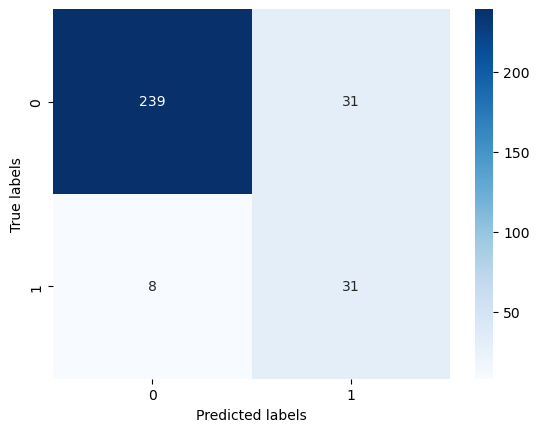

In [46]:
# Generate the confusion matrix
y_pred = np.where(y_pred > loaded_cutoff, 1, 0)

cm = confusion_matrix(y_cat, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Calculate the metrics
tn, fp, fn, tp = cm.ravel()
negative_prediction_rate = tn / (tn + fn)
positive_prediction_rate = tp / (tp + fp)
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_pred, y_cat)
sensitivity = tp / (tp + fn)

print(f'Negative prediction rate: {negative_prediction_rate}')
print(f'Positive prediction rate: {positive_prediction_rate}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')
print(f'Sensitivity: {sensitivity}')

# Neural network test

In [47]:
# load the model from json file
json_file = open('models/final_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("models/final_weights.h5")

In [48]:
y_pred = loaded_model.predict(X)

10/10 [==============================] - 0s 1ms/step


Negative prediction rate: 0.9836065573770492
Positive prediction rate: 0.5384615384615384
Specificity: 0.8888888888888888
Accuracy: 0.889967637540453
Sensitivity: 0.8974358974358975


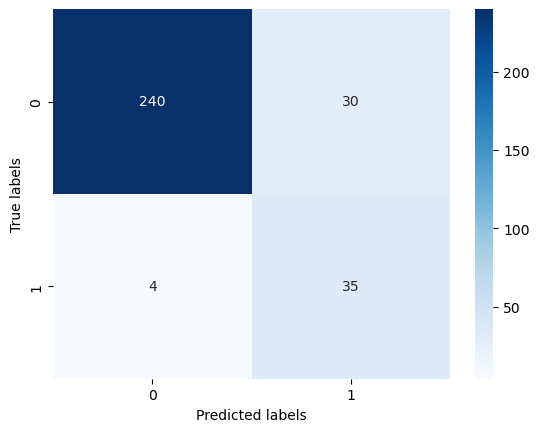

In [49]:
# import the cutoff value from the file 
filename = 'models/final_cutoff.pkl'
cutoff = pickle.load(open(filename, 'rb'))

y_pred = np.where(y_pred > cutoff, 1, 0)

# Generate the confusion matrix
cm = confusion_matrix(y_cat, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# Calculate the metrics
tn, fp, fn, tp = cm.ravel()
negative_prediction_rate = tn / (tn + fn)
positive_prediction_rate = tp / (tp + fp)
specificity = tn / (tn + fp)
accuracy = accuracy_score(y_pred, y_cat)
sensitivity = tp / (tp + fn)

print(f'Negative prediction rate: {negative_prediction_rate}')
print(f'Positive prediction rate: {positive_prediction_rate}')
print(f'Specificity: {specificity}')
print(f'Accuracy: {accuracy}')
print(f'Sensitivity: {sensitivity}')

In [50]:
# add the prediction to the dataframe as the fourth column
df_features['prediction'] = y_pred

In [51]:
df_results = df_features[['patient_id', 'total_score', 'label','prediction']]
# print the rows where the prediction is different from the label
df_results[df_results.label != df_results.prediction]

,patient_id,total_score,label,prediction
1,2125,37.6,0,1
4,2238,145.1,1,0
11,2252,0.0,0,1
14,2007,0.0,0,1
17,2182,32.2,0,1
28,2070,0.0,0,1
32,2065,0.0,0,1
33,2275,94.0,0,1
42,2281,60.4,0,1
47,2129,53.7,0,1
